#### Energy Usage

##### Import Data

In [25]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [26]:
main_df = pd.read_csv("dataset1_combined.csv")

# cataset could be gotten from the following link: https://zenodo.org/records/10069402

In [27]:
display(main_df.head())

print(f"\nDimensions: {main_df.shape[0]} rows × {main_df.shape[1]} columns")

,Series,Time,CPU_Load,Power,Network_RX,Network_TX,Inlet_Temperature,CPU1_Temperature,CPU2_Temperature,Fan_speed1,Fan_speed2,Fan_speed3,Fan_speed4,Ram,Ram_Used,No_Of_Running_vms,CPU_cores,CPU_cores_used
0,qh2-rcc120,2018-10-09 11:20:00,3.468500,90.533333,408343.338389,147737.953254,16.966667,37.083333,36.716667,7502.833333,7571.666667,7500.500000,7462.000000,64.454875,37.70275,15.0,64.0,63.0
1,qh2-rcc120,2018-10-09 11:30:00,3.622833,88.933333,44589.407008,202395.924763,17.000000,37.783333,37.083333,7141.166667,7182.000000,7147.000000,7113.166667,64.454875,37.70275,15.0,64.0,63.0
2,qh2-rcc120,2018-10-09 11:40:00,3.414500,88.800000,40146.872453,157905.963285,17.000000,38.233333,37.466667,6728.166667,6802.833333,6743.333333,6729.333333,64.454875,37.70275,15.0,64.0,63.0
3,qh2-rcc120,2018-10-09 11:50:00,3.332500,89.866667,441692.385339,142941.034500,17.000000,38.183333,37.550000,6813.333333,6856.500000,6808.666667,6771.333333,64.454875,37.70275,15.0,64.0,63.0
4,qh2-rcc120,2018-10-09 12:00:00,3.364000,89.600000,422057.822324,770341.893781,16.950000,37.416667,36.866667,7390.833333,7445.666667,7401.333333,7351.166667,64.454875,37.70275,15.0,64.0,63.0



Dimensions: 2748525 rows × 18 columns


In [28]:
# change Series to int

main_df['Series'] = main_df['Series'].str.strip().str.extract(r'(\d+)$').astype(int)

In [29]:
# check duplicates, drop if any

num_duplicates = main_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

main_df.drop_duplicates(inplace=True)

Number of duplicate rows: 0


In [30]:
print("Null values in main_df:")
print(main_df.isnull().sum())

Null values in main_df:
Series                   0
Time                     0
CPU_Load                85
Power                   83
Network_RX              83
Network_TX              86
Inlet_Temperature    83799
CPU1_Temperature        86
CPU2_Temperature        91
Fan_speed1           83800
Fan_speed2           83799
Fan_speed3           83793
Fan_speed4           83793
Ram                  10489
Ram_Used             10489
No_Of_Running_vms    10489
CPU_cores            10489
CPU_cores_used       10944
dtype: int64


In [31]:
main_df.dtypes

Series                 int64
Time                  object
CPU_Load             float64
Power                float64
Network_RX           float64
Network_TX           float64
Inlet_Temperature    float64
CPU1_Temperature     float64
CPU2_Temperature     float64
Fan_speed1           float64
Fan_speed2           float64
Fan_speed3           float64
Fan_speed4           float64
Ram                  float64
Ram_Used             float64
No_Of_Running_vms    float64
CPU_cores            float64
CPU_cores_used       float64
dtype: object

In [32]:
main_df['Time'] = pd.to_datetime(main_df['Time'], format='%Y-%m-%d %H:%M:%S')

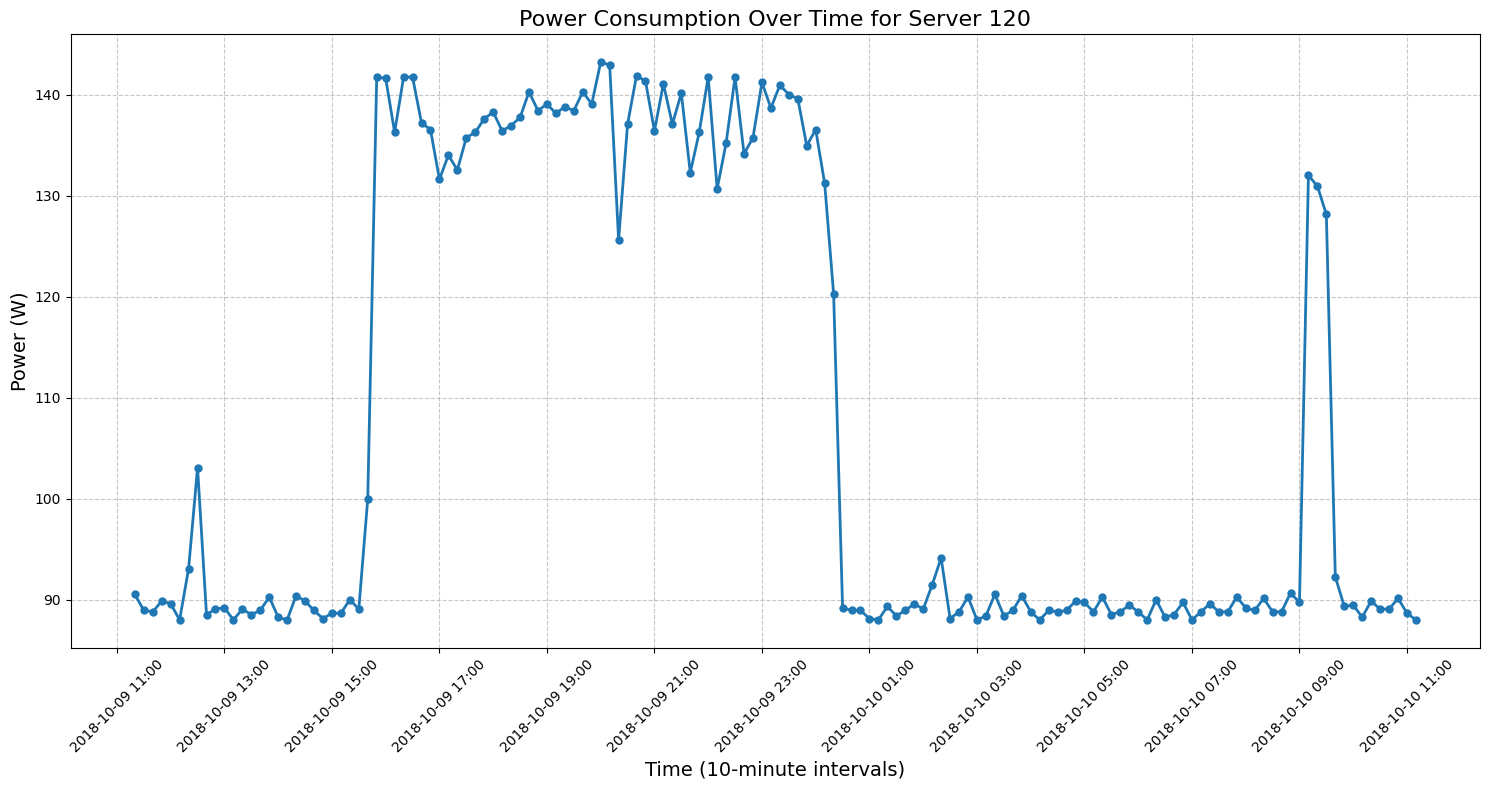

In [33]:
plt.figure(figsize=(15, 8))

server_series = main_df['Series'].unique()[0]
server_df = main_df[main_df['Series'] == server_series]

server_df = server_df.sort_values('Time').head(144)

plt.plot(server_df['Time'], server_df['Power'], marker='o', linestyle='-', linewidth=2, markersize=5)
plt.title(f'Power Consumption Over Time for Server {server_series}', fontsize=16)
plt.xlabel('Time (10-minute intervals)', fontsize=14)
plt.ylabel('Power (W)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))

plt.tight_layout()
plt.show()

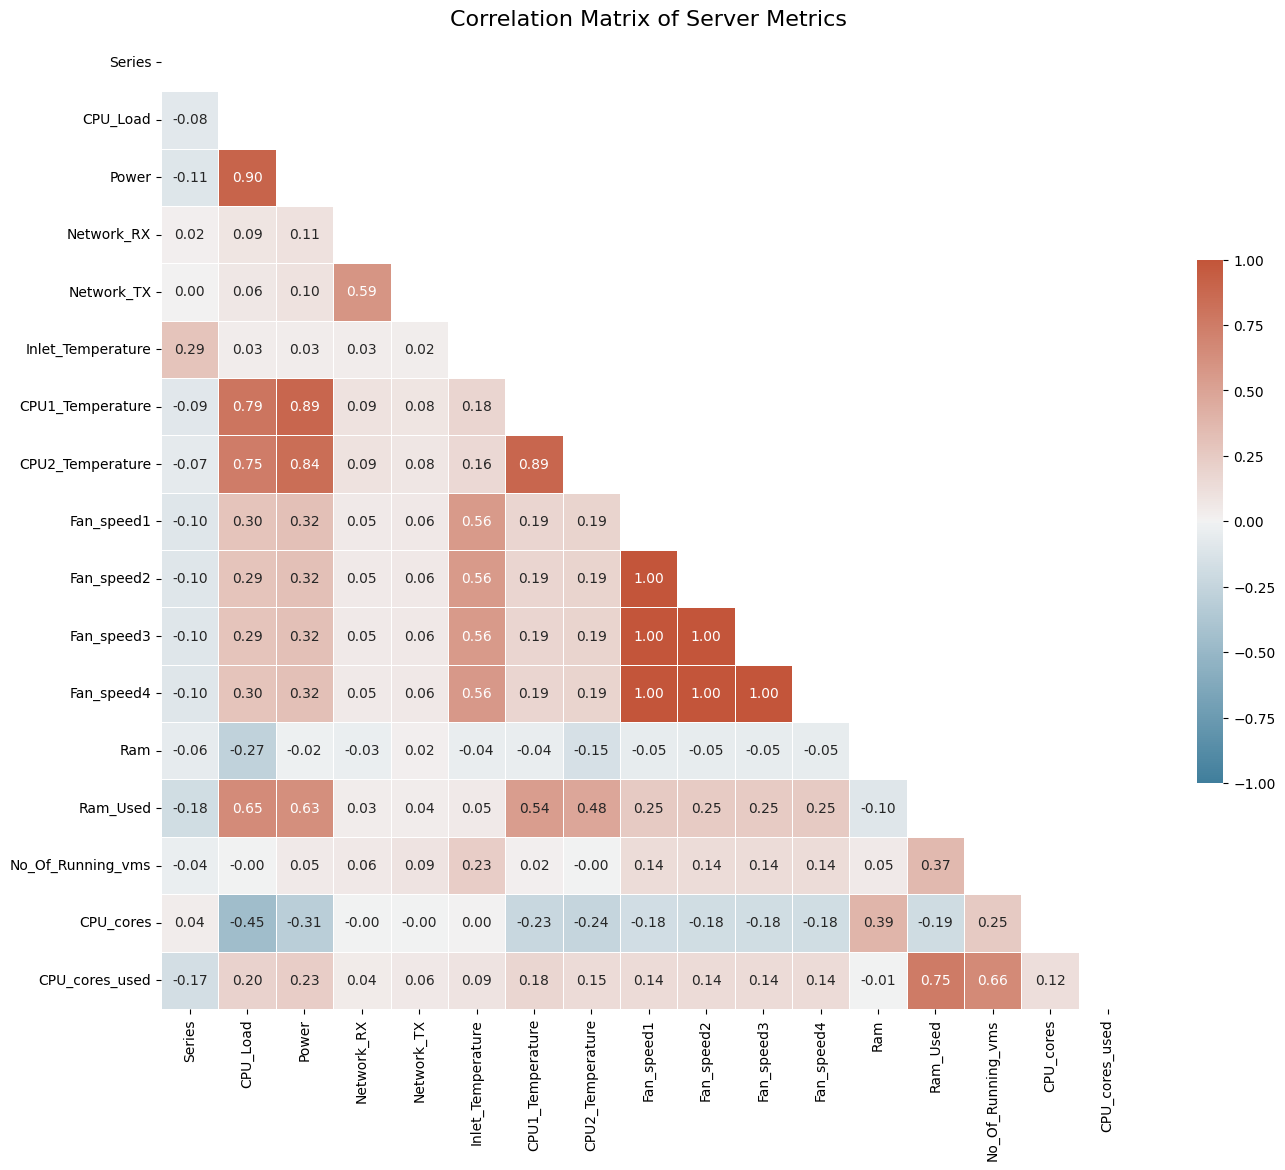

In [34]:
# check correlation between numerical columns

numerical_cols = main_df.select_dtypes(include=[np.number]).columns.tolist()

correlation = main_df[numerical_cols].corr()


plt.figure(figsize=(14, 12))

mask = np.triu(np.ones_like(correlation, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Correlation Matrix of Server Metrics', fontsize=16)
plt.tight_layout()
plt.show()

##### Preprocessing

In [35]:
# since this is not a time series data nor a time series prediction, we will drop the time column
main_df.drop(columns=['Time'], inplace=True)

In [36]:
# drop 3 of the fan speed columns, because they are highly correlated with each other
main_df.drop(columns=['Fan_speed1', 'Fan_speed2', 'Fan_speed3'], inplace=True)

In [37]:
# Series doesn't add any value to the data, so we will drop it
main_df.drop(columns=['Series'], inplace=True)

In [38]:
# drop missing values
main_df = main_df.dropna()

In [39]:
# normalize numerical data

feature_cols = main_df.columns.drop('Power')
scaler = StandardScaler()
main_df[feature_cols] = scaler.fit_transform(main_df[feature_cols])
# main_df.loc[:, feature_cols] = scaler.fit_transform(main_df[feature_cols])


In [40]:
display(main_df.head())

print(f"\nDimensions: {main_df.shape[0]} rows × {main_df.shape[1]} columns")

,CPU_Load,Power,Network_RX,Network_TX,Inlet_Temperature,CPU1_Temperature,CPU2_Temperature,Fan_speed4,Ram,Ram_Used,No_Of_Running_vms,CPU_cores,CPU_cores_used
0,-0.498945,90.533333,-0.142682,-0.147473,-0.209463,-1.773199,-1.295380,-0.501958,-2.145954,0.107654,0.934021,-0.816364,0.313488
1,-0.488174,88.933333,-0.163269,-0.143751,-0.200371,-1.710647,-1.253326,-0.632478,-2.145954,0.107654,0.934021,-0.816364,0.313488
2,-0.502713,88.800000,-0.163520,-0.146781,-0.200371,-1.670435,-1.209359,-0.776094,-2.145954,0.107654,0.934021,-0.816364,0.313488
3,-0.508436,89.866667,-0.140794,-0.147800,-0.200371,-1.674903,-1.199801,-0.760379,-2.145954,0.107654,0.934021,-0.816364,0.313488
4,-0.506238,89.600000,-0.141905,-0.105070,-0.214009,-1.743412,-1.278176,-0.543427,-2.145954,0.107654,0.934021,-0.816364,0.313488



Dimensions: 2653869 rows × 13 columns


##### Training and Validation

In [41]:
def smape(actual, forecast):
    value = 100 * np.mean(2 * np.abs(actual - forecast) / (np.abs(actual) + np.abs(forecast)))
    return round(float(value), 2)
def accuracy(y_true, y_pred):
    value = 100 - smape(y_true, y_pred)
    return round(float(value), 2)

In [42]:
X = main_df.drop(columns=['Power'])
y = main_df['Power']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
# model linear regression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
lr_train = model.predict(X_valid)
smape(y_valid, lr_train)

5.4

94.6


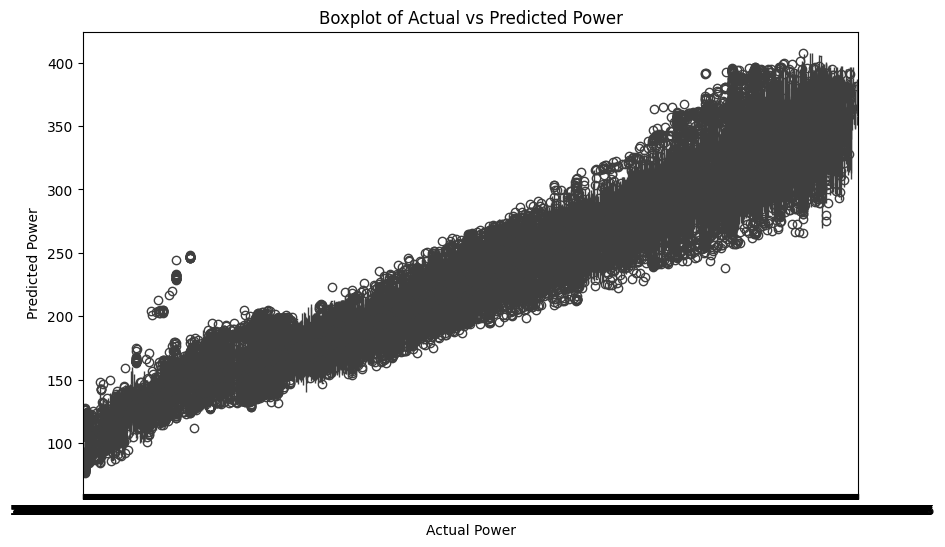

In [45]:
# check accuracy percentage
print(accuracy(y_valid, lr_train))

plt.figure(figsize=(10, 6))
sns.boxplot(x=y_valid, y=lr_train)
plt.xlabel("Actual Power")
plt.ylabel("Predicted Power")
plt.title("Boxplot of Actual vs Predicted Power")
plt.show()

In [46]:
mse = mean_squared_error(y_valid, lr_train)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, lr_train)
r2 = r2_score(y_valid, lr_train)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² score: {r2:.4f}")


MSE: 187.53
RMSE: 13.69
MAE: 10.47
R² score: 0.9569


<Axes: title={'center': 'Feature Importance'}>

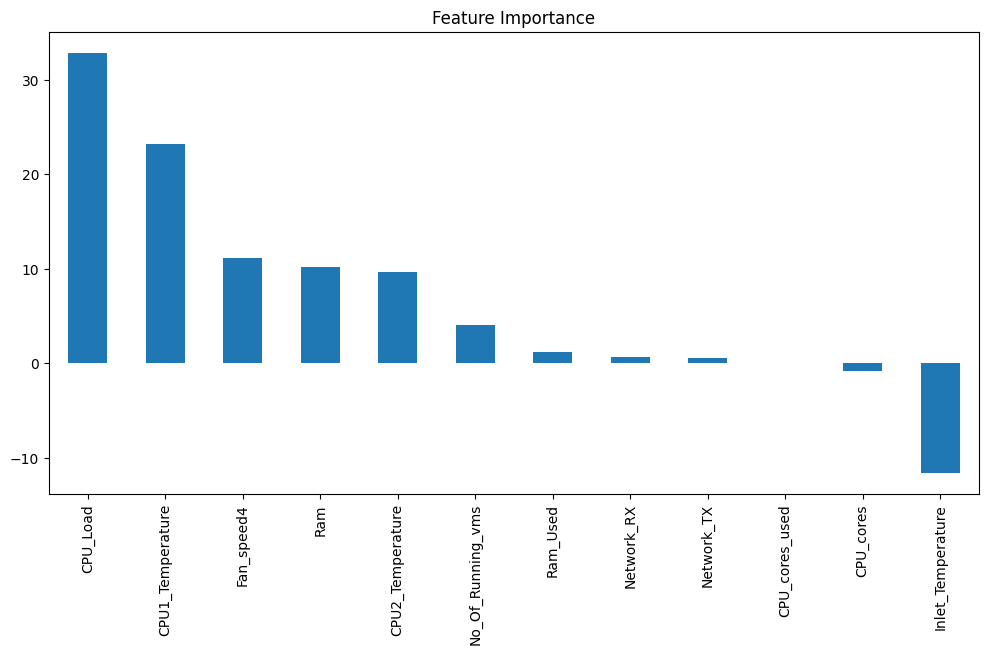

In [47]:
importance = pd.Series(model.coef_, index=X_train.columns)
importance.sort_values(ascending=False).plot(kind='bar', figsize=(12,6), title="Feature Importance")
